
Numerical optimization
======================

Silent substitution can be approached as a [constrained numerical optimization](https://en.wikipedia.org/wiki/Constrained_optimization) problem of the form:

\begin{equation}
\begin{array}{rrclcl}
& \underset{x \in \mathbb{R}^{n}}{\text{minimize}}
&  f(x) \\
& \text{subject to}
& g^{L} \le g(x) \le g^{U} \\
& & x^{L} \le x \le x^{U} ,
\end{array}
\end{equation}

where $x \in \mathbb{R}^{n}$ are the optimization variables (i.e., the primary input weights) whose lower and upper bounds, $x^{L}$ and $x^{U}$, are between 0 and 1 to ensure that the solution is within the gamut of the device, $f(x)$ is the objective function that aims to maximise contrast of the target photoreceptor(s), and $g(x)$ is a constraint function that calculates contrast for the silenced photoreceptor(s), where $g^{L}$ and $g^{U}$ should be zero. In all cases, $x$ is a vector containing the primary input weights. 

`pysilsub.problems.SilentSubstitutionProblem` has an `.optim_solve()` method that uses `SciPy`'s optimisation algorithms to solve a defined problem. By default, it performs a local optimisation with `scipy.optimize.minimize` using the `SLSQP` [sequential quadratic least squares programming](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/optimize.minimize-slsqp.html) solver. 

The objective function, $f(x)$, and the contrast constraint function, $g(x)$, are built into the problem class and are conditioned by the values given to the properties.


Basic example
-------------

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Ignoring: ['R']
Minimising: ['M', 'L', 'I']
Modulating: ['S']
Target contrast: 0.1


> Performing local optimization with SLSQP.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.700106698215687e-10
            Iterations: 22
            Function evaluations: 248
            Gradient evaluations: 22


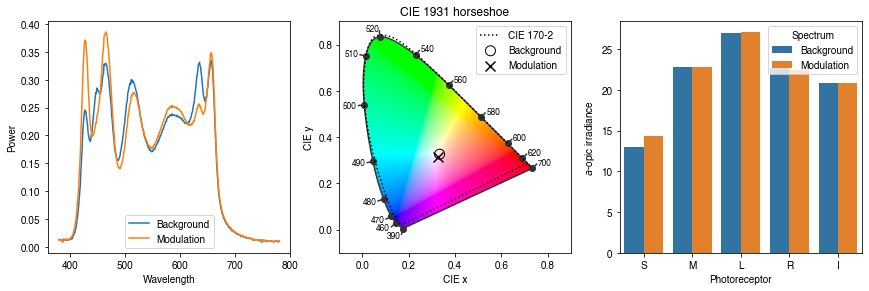

In [13]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Instantiate the problem class
ssp = SSP.from_json('../../data/STLAB_1_York.json')

# Define problem
ssp.ignore = ['rh']
ssp.modulate = ['sc']
ssp.minimize = ['mc', 'lc', 'mel']
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .1
ssp.print_problem()

# Find solution
solution = ssp.optim_solve()

# Plot solution
fig = ssp.plot_solution(solution.x)

In [14]:
ssp.print_photoreceptor_contrasts(solution.x)

Photoreceptor
S    0.099972
M   -0.000093
L    0.000482
R   -0.007610
I    0.000208
dtype: float64



Maximising contrast
-------------------

If you want `.optim_solve(...)` to maximise contrast rather than aim for a target value, don't set the `target_contrast` property, or set it back to its default value, `None`.

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Ignoring: ['R']
Minimising: ['M', 'L', 'I']
Modulating: ['S']
Target contrast: None


> No target contrast specified, will aim to maximise.
> Performing local optimization with SLSQP.
Iteration limit reached    (Exit mode 9)
            Current function value: -0.31814951481598563
            Iterations: 100
            Function evaluations: 1182
            Gradient evaluations: 100


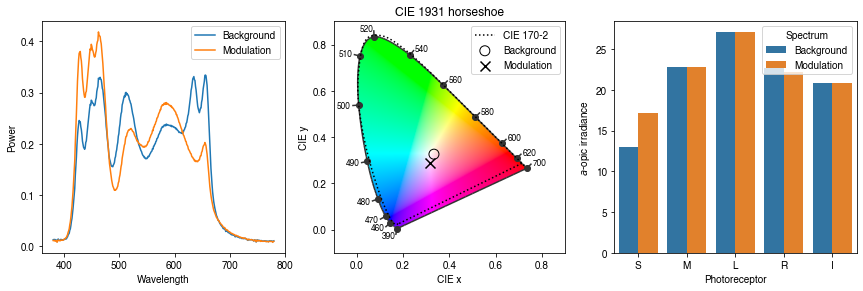

In [16]:
ssp.target_contrast = None
ssp.print_problem()

# Find solution
solution = ssp.optim_solve()

# Plot solution
_ = ssp.plot_solution(solution.x)

In [17]:
ssp.print_photoreceptor_contrasts(solution.x)

Photoreceptor
S    0.318150
M   -0.000010
L    0.000005
R   -0.019018
I    0.000004
dtype: float64



### Optimising the background

It often makes sense to stick with a specific background spectrum, particularly if you plan on targeting different photoreceptors in the same experiment. But when you specify a background spectrum, `.optim_solve()` will only optimize the modulation spectrum. This is a big constraint on the optimisation and is why in this case we only got about 21% contrast on melanopsin.

If you don't care what the background spectrum is, set the `background` property to `None`. `.optim_solve()` will now also optimise the background and should be able to find more contrast.

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Background: None
Ignoring: ['R']
Minimising: ['M', 'L', 'I']
Modulating: ['S']
Target contrast: None


> No background specified, will optimise background.
> No target contrast specified, will aim to maximise.
> Performing local optimization with SLSQP.
Iteration limit reached    (Exit mode 9)
            Current function value: -7.472442908299183
            Iterations: 100
            Function evaluations: 2200
            Gradient evaluations: 99


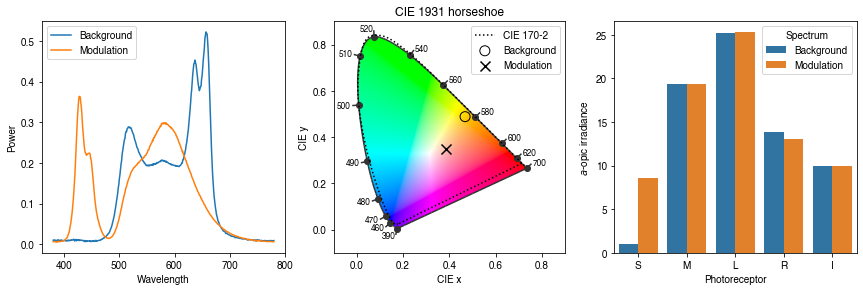

In [21]:
ssp.background = None
ssp.print_problem()
solution = ssp.optim_solve()
_ = ssp.plot_solution(solution.x)

747% contrast!

In [22]:
ssp.print_photoreceptor_contrasts(solution.x)

Photoreceptor
S    7.472443
M   -0.002748
L    0.002035
R   -0.055404
I    0.002057
dtype: float64



Local vs. global optimisation
-----------------------------

By default, `.optim_solve()` uses *Scipy's* `minimize` function, which is a *local* minimizer. It starts with an initial random guess for the primary inputs and works from that point to minimize the objective function (which in this case was to maximize contrast). 

Due to the random nature of the starting point in the function landscape, the minimum it finds is unlikely to be the global minimum. 

If you have enough time, you can tell `.optim_solve()` to search for the global minimum, in which case it will use *Scipy's* `basinhopping` algorithm to perform a series of local searches, each with a different starting point. 


> No background specified, will optimise background.
> No target contrast specified, will aim to maximise.
> Performing global optimization with basinhopping and SLSQP
basinhopping step 0: f -6.61984
basinhopping step 1: f -9.38603 trial_f -9.38603 accepted 1  lowest_f -9.38603
found new global minimum on step 1 with function value -9.38603
basinhopping step 2: f -9.38603 trial_f -7.3331 accepted 0  lowest_f -9.38603
basinhopping step 3: f -9.38603 trial_f -6.74886 accepted 0  lowest_f -9.38603
basinhopping step 4: f -9.38603 trial_f -4.72474 accepted 0  lowest_f -9.38603
basinhopping step 5: f -9.38603 trial_f -2.68885 accepted 0  lowest_f -9.38603
basinhopping step 6: f -9.38603 trial_f -0.990906 accepted 0  lowest_f -9.38603
basinhopping step 7: f -9.38603 trial_f -6.04105 accepted 0  lowest_f -9.38603
basinhopping step 8: f -9.38603 trial_f -3.74292 accepted 0  lowest_f -9.38603
basinhopping step 9: f -9.38603 trial_f -7.46262 accepted 0  lowest_f -9.38603
basinhopping step 10: f -

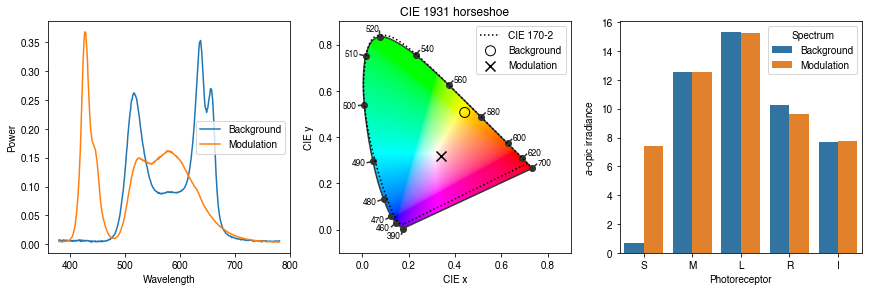

In [23]:
solution = ssp.optim_solve(global_search=True)
fig = ssp.plot_solution(solution.x)


Using an external optimiser
---------------------------

For example, ipopt is a fast nonlinear optimizer. 

*'Ipopt (Interior Point OPTimizer, pronounced eye-pea-Opt) is a software package for large-scale nonlinear optimization. cyipopt is a python wrapper around Ipopt. It enables using Ipopt from the comfort of the great Python scripting language. Ipopt is available from the COIN-OR initiative, under the Eclipse Public License (EPL).'*

In [2]:
# from cyipopt import minimize_ipopt

# # Define problem
# ssp.ignore = ['R']
# ssp.modulate = ['I']
# ssp.minimize = ['S', 'M', 'L']
# ssp.background = [.5] * ssp.nprimaries
# ssp.target_contrast = None
# ssp.print_problem()

# # Set up optimisation
# result = minimize_ipopt(
#     fun=ssp.objective_function,
#     x0=ssp.initial_guess_x0(),
#     args=(),
#     bounds=ss.bounds,
#     constraints=constraints,
#     tol=1e-5,
#     options={b"print_level": 5, b"constr_viol_tol": 1e-5},
# )
